In [0]:
%run ./transform_data

# Transform data
In this notebook we perform transformations required to get required features for modelling.

# Transform data
First we will clean variables that contain values that are interpreted as missing or 0 values.

+--------------+-----+
|_AGEG5YR_clean|count|
+--------------+-----+
|           1.0|29692|
|           6.0|28968|
|           4.0|28804|
|           5.0|30899|
|           8.0|34936|
|           NaN| 8310|
|          10.0|47701|
|           7.0|31698|
|          13.0|41756|
|          11.0|44774|
|           2.0|23705|
|           9.0|43387|
|          12.0|36803|
|           3.0|26237|
+--------------+-----+



+------------------+------+
|CHILDREN_clean_mod| count|
+------------------+------+
|              14.0|    13|
|              NULL|  5606|
|              23.0|     1|
|               0.0|336299|
|              32.0|     2|
|              22.0|     3|
|              29.0|     1|
|              18.0|     1|
|               1.0| 48206|
|               6.0|   695|
|              25.0|     1|
|              15.0|     5|
|               4.0|  5672|
|              41.0|     1|
|               5.0|  1854|
|               8.0|   127|
|              81.0|    12|
|              17.0|     2|
|              20.0|     2|
|              82.0|     3|
+------------------+------+
only showing top 20 rows


Next we will calculate income relative to poverty threshold. To do this we first make new variables with children capped at 8 and adults at 9. 

+--------------------+------+
|          ADULT_cap9| count|
+--------------------+------+
|                NULL| 81961|
|                 1.0| 96588|
|                 6.0|  2788|
|                 4.0| 26067|
|                 5.0|  8557|
|                 8.0|   402|
|5.397605346934028...|     1|
|                 7.0|   911|
|                 2.0|182543|
|                 9.0|  4096|
|                 3.0| 53756|
+--------------------+------+



Now we have capped variables, we read in the poverty data generated in the convert_census notebook and bin to match the BRFSS data. 

+----------------------+------+
|poverty_threshold_conv| count|
+----------------------+------+
|                  NULL|144700|
|                     2| 79243|
|                     7| 16199|
|                     3|176715|
|                     5|  3586|
|                     4| 32908|
|                     6|  4319|
+----------------------+------+



# Select features and filter

[('_AGEG5YR_clean', 'double'),
 ('EDUCA_clean', 'double'),
 ('_BMI5', 'double'),
 ('_SMOKER3_clean', 'double'),
 ('DRNKANY6_clean', 'double'),
 ('INCOME3_clean', 'double'),
 ('num_conditions', 'int'),
 ('income_adj_pov', 'double'),
 ('RFHLTH_adj', 'double')]

+--------------+-----------+-----+--------------+--------------+-------------+--------------+--------------+----------+
|_AGEG5YR_clean|EDUCA_clean|_BMI5|_SMOKER3_clean|DRNKANY6_clean|INCOME3_clean|num_conditions|income_adj_pov|RFHLTH_adj|
+--------------+-----------+-----+--------------+--------------+-------------+--------------+--------------+----------+
|          8310|       2363|43037|         32022|         43777|        87423|             0|        199183|      1310|
+--------------+-----------+-----+--------------+--------------+-------------+--------------+--------------+----------+



229399
457670


We lose a significant proportion of rows (1/2) when we require all values to be present. The 2 major contributors are INCOME3 and income_adj_pov, which derives from missing INCOME3 values and missing children/adults. A more thorough treatment could attempt to impute some of these values. 

+----------+------+
|RFHLTH_adj| count|
+----------+------+
|       0.0|185479|
|       1.0| 43920|
+----------+------+



In [0]:
# The following imports are not used in this notebook:

from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, GBTClassificationModel, RandomForestClassificationModel
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
# databricks requires us to set SPARKML_TEMP_DFS_PATH, but this cannot be done via spark config on serverless compute so we use this workaround, same with MLFLOW_DFS_TMP
import os
os.environ["SPARKML_TEMP_DFS_PATH"] = "/Volumes/pophealthrisk/pophealthrisk/pophealthrisk/ml-temp"
os.environ["MLFLOW_DFS_TMP"] = "/Volumes/pophealthrisk/pophealthrisk/pophealthrisk/ml-temp"

# Hyperparameter tuning approach
As we have a large amount of data we will take a train, validate, test approach, as we can assume that sampling effects will be minimal. For smaller data sets, where sampling bias could have an impact, a cross-validation approach would be more appropriate. 

# Model choice
We consider gradient boosted trees and random forest classifiers as these often perform well on this kind of tabular data. 

In [0]:
# balance dataset
balanced_df = df_min.sampleBy("RFHLTH_adj", fractions={0: 0.25, 1: 1}, seed=10)
balanced_df.groupBy('RFHLTH_adj').count().show()

+----------+-----+
|RFHLTH_adj|count|
+----------+-----+
|       0.0|46486|
|       1.0|43920|
+----------+-----+



In [0]:
# split data into train and test sets
train, test =balanced_df.randomSplit(weights=[0.8,0.2], seed=200)
print(test.count())
print(train.count())

18022
72384


In [0]:
feature_cols=["_AGEG5YR_clean","EDUCA_clean",'_BMI5', '_SMOKER3_clean', 'DRNKANY6_clean','INCOME3_clean','num_conditions','income_adj_pov']

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

train_assembled = assembler.transform(train)

In [0]:
evaluator = BinaryClassificationEvaluator(
    labelCol="RFHLTH_adj",
    rawPredictionCol="probability"
)

In [0]:
rf = RandomForestClassifier(
    labelCol="RFHLTH_adj",
    seed=42
)
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [100, 200, 300])
             .addGrid(rf.maxDepth, [4,6,8])
             .build())

In [0]:
gbt = GBTClassifier(
    labelCol="RFHLTH_adj",
    seed=42
)
paramGridGbt = (ParamGridBuilder()
             .addGrid(gbt.maxIter, [20,40,60,80])
             .addGrid(gbt.maxDepth, [4,6,8])
             .build())

In [0]:
cv_gbt = CrossValidator(
    estimator=gbt,
    estimatorParamMaps=paramGridGbt,
    evaluator=evaluator,
    numFolds=3,  # or 5
    parallelism=4
)
cv_gbt_fit = cv_gbt.fit(train_assembled)

In [0]:
cv_rf = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3,  # or 5
    parallelism=4
)
cv_rf_fit = cv_rf.fit(train_assembled)

In [0]:
rf_results = [
    (param[rf.numTrees], param[rf.maxDepth], metric)
    for param, metric in zip(paramGrid, cv_rf_fit.avgMetrics)
]
rf_df = pd.DataFrame(rf_results, columns=["Trees_or_Iters", "maxDepth", "Mean_F1"])
rf_df["Model"] = "RandomForest"

# --- GBT results ---
gbt_results = [
    (param[gbt.maxIter], param[gbt.maxDepth], metric)
    for param, metric in zip(paramGridGbt, cv_gbt_fit.avgMetrics)
]
gbt_df = pd.DataFrame(gbt_results, columns=["Trees_or_Iters", "maxDepth", "Mean_F1"])
gbt_df["Model"] = "GBT"

# Combine results
results_df = pd.concat([rf_df, gbt_df], ignore_index=True)

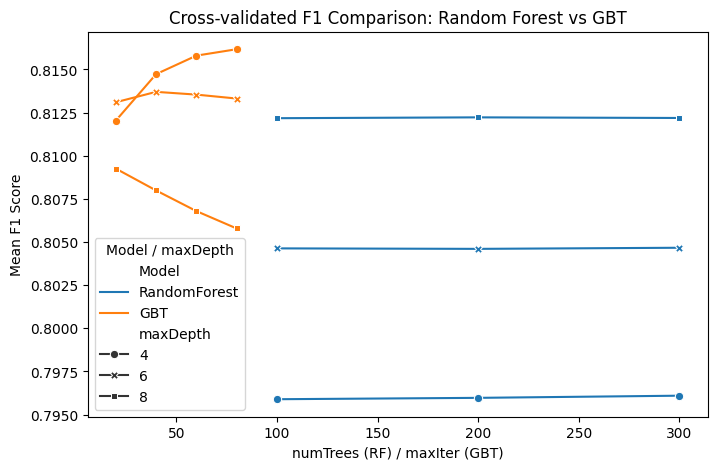

In [0]:
plt.figure(figsize=(8,5))
sns.lineplot(
    data=results_df,
    x="Trees_or_Iters",
    y="Mean_F1",
    hue="Model",
    style="maxDepth",
    markers=True,
    dashes=False
)
plt.title("Cross-validated F1 Comparison: Random Forest vs GBT")
plt.ylabel("Mean F1 Score")
plt.xlabel("numTrees (RF) / maxIter (GBT)")
plt.legend(title="Model / maxDepth")
plt.show()

In [0]:
# train final model
gbt_optimal =  GBTClassifier(
    labelCol="RFHLTH_adj",
    seed=42,
    maxIter=80,
    maxDepth=4
)
final_model = gbt_optimal.fit(train_assembled)

In [0]:
# save model, this is a quick save so that we do not need to retrain every time
final_model.write().overwrite().save("/Volumes/pophealthrisk/pophealthrisk/pophealthrisk/models/gbt-1")

In [0]:
# load model
final_model = GBTClassificationModel.load("/Volumes/pophealthrisk/pophealthrisk/pophealthrisk/models/gbt-1")

In [0]:
test_assembled = assembler.transform(test)

In [0]:
preds = final_model.transform(test_assembled)
evaluator.setMetricName("areaUnderROC")
auc = evaluator.evaluate(preds)
print("Validation AUC:", auc)

Validation AUC: 0.8143577740490603


In [0]:
from pyspark.sql import functions as F

# Calculate accuracy
accuracy = preds.filter(
    F.col("prediction") == F.col("RFHLTH_adj")
).count() / preds.count()

# True Positives, False Positives, False Negatives
tp = preds.filter((F.col("prediction") == 1) & (F.col("RFHLTH_adj") == 1)).count()
fp = preds.filter((F.col("prediction") == 1) & (F.col("RFHLTH_adj") == 0)).count()
fn = preds.filter((F.col("prediction") == 0) & (F.col("RFHLTH_adj") == 1)).count()

# Precision, Recall, F1
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")

# Confusion matrix
confusion_df = preds.groupBy(
    "RFHLTH_adj", "prediction"
).count().groupBy(
    "RFHLTH_adj"
).pivot(
    "prediction"
).sum("count").fillna(0)

display(confusion_df)

Accuracy: 0.735
Precision: 0.726
Recall: 0.732
F1-score: 0.729


RFHLTH_adj,0.0,1.0
1.0,2351,6432
0.0,6817,2422


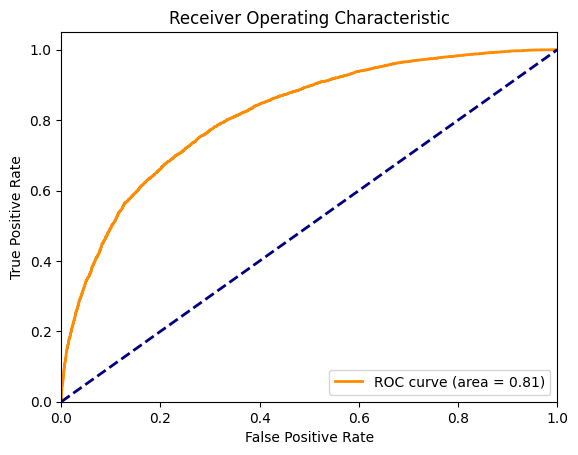

In [0]:
# Get probability and label columns as pandas DataFrame
roc_data = (
    preds
    .select("RFHLTH_adj", "probability")
    .toPandas()
)

# Extract probability for class 1
roc_data["prob_1"] = roc_data["probability"].apply(lambda x: float(x[1]))

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(roc_data["RFHLTH_adj"], roc_data["prob_1"])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

In [0]:
# Log with mlflow for deployment
import mlflow
import mlflow.spark
from mlflow.models import infer_signature
from mlflow import MlflowClient

example_df = test_assembled.limit(1).toPandas()
predicted_df = final_model.transform(test_assembled.limit(1)).toPandas()
signature = infer_signature(example_df, predicted_df)

model_info = mlflow.spark.log_model(final_model, "PHR_GBT",signature=signature)
mlflow.register_model(model_info.model_uri, "PopHealthRisk.PopHealthRisk.PHR_GBT")

client = MlflowClient()
client.set_registered_model_alias("pophealthrisk.pophealthrisk.phr_gbt", "prod", 1)

2025/10/19 20:27:12 WARNING mlflow.models.signature: Failed to infer schema for inputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. Note that MLflow doesn't validate data types during inference for AnyType. To see the full traceback, set logging level to DEBUG.
2025/10/19 20:27:12 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/10/19 20:27:20 WARNING mlflow.utils.requirements_utils: Found pyspark version (4.0.0+databricks.connect.17.1.2) contains a local version label (+databricks.connect.17.1.2). MLflow logged a pip requirement for this package as 'pyspark==4.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/19 20:27:24 WARNING mlflow.utils.environment: Encountered an unexpected error wh

# Summary
Predictive performance is limited but good enough for this exercise. Due to balancing of the training set, we have fairly balanced predictions without bias. 